In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the raw data (we'll process it now)
df = pd.read_csv('../data/raw/marketing_data.csv')
df['week'] = pd.to_datetime(df['week'])
df.set_index('week', inplace=True)

# Display the first few rows to confirm loading
df.head()

,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
week,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [2]:
# For media spend columns, we'll add a small constant to avoid issues with log transformations
# We'll also create binary flags to indicate when spending occurred
spend_cols = ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']

# Add a small constant (e.g., 1) to all spend values to avoid log(0)
df[spend_cols] = df[spend_cols] + 1

# Create binary flags for each spend channel indicating if there was spending
for col in spend_cols:
    df[f'{col}_flag'] = (df[col] > 1).astype(int)  # Since we added 1, original zeros are now 1, so >1 means there was spend

In [3]:
# Extract time-based features to capture trends and seasonality
df['week_of_year'] = df.index.isocalendar().week
df['month'] = df.index.month
df['quarter'] = df.index.quarter

# Create a linear trend feature (number of weeks since start)
df['trend'] = (df.index - df.index.min()).days / 7

In [4]:
# Apply log transformation to media spends to capture diminishing returns
for col in spend_cols:
    df[f'log_{col}'] = np.log(df[col])

# Also log transform other continuous variables that might have skewed distributions
# For example, revenue, emails_send, sms_send, social_followers
df['log_revenue'] = np.log(df['revenue'])
df['log_emails_send'] = np.log(df['emails_send'] + 1)  # Adding 1 in case of zeros
df['log_sms_send'] = np.log(df['sms_send'] + 1)
df['log_social_followers'] = np.log(df['social_followers'] + 1)

# For average_price, we might not log it if it's normally distributed, but let's check skewness
# Alternatively, we can use it as is or scale it later.

In [5]:
# We'll scale all features except the flags and time-based features for modeling
# First, define which features to scale
features_to_scale = [
    'log_facebook_spend', 'log_google_spend', 'log_tiktok_spend', 
    'log_instagram_spend', 'log_snapchat_spend',
    'average_price', 'promotions', 'log_emails_send', 'log_sms_send', 
    'log_social_followers', 'trend'
]

# Initialize the scaler
scaler = StandardScaler()

# Scale the features and create a new DataFrame for scaled values
scaled_features = scaler.fit_transform(df[features_to_scale])
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale, index=df.index)

# Add the flags and time-based features back to the scaled DataFrame
df_scaled['facebook_spend_flag'] = df['facebook_spend_flag']
df_scaled['google_spend_flag'] = df['google_spend_flag']
df_scaled['tiktok_spend_flag'] = df['tiktok_spend_flag']
df_scaled['instagram_spend_flag'] = df['instagram_spend_flag']
df_scaled['snapchat_spend_flag'] = df['snapchat_spend_flag']
df_scaled['week_of_year'] = df['week_of_year']
df_scaled['month'] = df['month']
df_scaled['quarter'] = df['quarter']

# The target variable is log_revenue
df_scaled['log_revenue'] = df['log_revenue']

# Display the scaled DataFrame
df_scaled.head()

,log_facebook_spend,log_google_spend,log_tiktok_spend,log_instagram_spend,log_snapchat_spend,average_price,promotions,log_emails_send,log_sms_send,log_social_followers,trend,facebook_spend_flag,google_spend_flag,tiktok_spend_flag,instagram_spend_flag,snapchat_spend_flag,week_of_year,month,quarter,log_revenue
week,,,,,,,,,,,,,,,,,,,,
2023-09-17,0.646622,1.118846,1.404146,1.162424,1.288843,0.307430,-0.517970,-0.650280,-0.411733,-1.729893,-1.715476,1,1,1,1,1,37,9,3,11.328091
2023-09-24,0.020281,1.082650,-0.726864,-0.805334,-0.805863,0.602873,-0.517970,-0.936804,0.948465,-1.729893,-1.682166,1,1,0,0,0,38,9,3,5.921632
2023-10-01,0.543419,-0.872659,-0.726864,-0.805334,-0.805863,0.064580,-0.517970,-0.925985,-0.055725,-1.729893,-1.648855,1,0,0,0,0,39,10,4,6.240295
2023-10-08,1.417405,-0.872659,-0.726864,-0.805334,-0.805863,0.491502,1.930615,-0.816277,-1.606171,-1.729893,-1.615545,1,0,0,0,0,40,10,4,6.115406
2023-10-15,0.120390,-0.872659,-0.726864,1.310060,-0.805863,1.206132,1.930615,0.106688,0.981099,-1.729893,-1.582235,1,0,0,1,0,41,10,4,10.632049


In [6]:
# Save the processed data to the 'processed' folder for modeling
df_scaled.to_csv('../data/processed/processed_marketing_data.csv')

In [7]:
# Import additional libraries for modeling
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load processed data
df_processed = pd.read_csv('../data/processed/processed_marketing_data.csv', index_col='week', parse_dates=True)

# Define stage 1 data: predict Google spend from social media
y1 = df_processed['log_google_spend']  # scaled log Google spend
social_spends = ['log_facebook_spend', 'log_tiktok_spend', 'log_instagram_spend', 'log_snapchat_spend']
social_flags = ['facebook_spend_flag', 'tiktok_spend_flag', 'instagram_spend_flag', 'snapchat_spend_flag']
time_features = ['trend', 'week_of_year', 'month', 'quarter']
X1 = df_processed[social_spends + social_flags + time_features]

# Define stage 2 data: predict revenue from predicted Google spend and controls
y2 = df_processed['log_revenue']  # scaled log revenue
controls = ['average_price', 'promotions', 'log_emails_send', 'log_sms_send', 'log_social_followers']
X2_base = df_processed[controls + time_features]  # base features without Google spend

# Initialize time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
fold_rmse = []
fold_r2 = []

# Iterate over folds
for train_index, test_index in tscv.split(X1):
    # Stage 1: Split data
    X1_train, X1_test = X1.iloc[train_index], X1.iloc[test_index]
    y1_train, y1_test = y1.iloc[train_index], y1.iloc[test_index]
    
    # Train Stage 1 model (Ridge regression)
    stage1_model = Ridge(alpha=1.0, random_state=42)
    stage1_model.fit(X1_train, y1_train)
    
    # Predict Google spend for train and test
    y1_pred_train = stage1_model.predict(X1_train)
    y1_pred_test = stage1_model.predict(X1_test)
    
    # Stage 2: Prepare data with predicted Google spend
    X2_train = X2_base.iloc[train_index].copy()
    X2_test = X2_base.iloc[test_index].copy()
    X2_train['pred_log_google_spend'] = y1_pred_train
    X2_test['pred_log_google_spend'] = y1_pred_test
    
    y2_train, y2_test = y2.iloc[train_index], y2.iloc[test_index]
    
    # Train Stage 2 model (Ridge regression)
    stage2_model = Ridge(alpha=1.0, random_state=42)
    stage2_model.fit(X2_train, y2_train)
    
    # Predict revenue for test data
    y2_pred_test = stage2_model.predict(X2_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y2_test, y2_pred_test))
    r2 = r2_score(y2_test, y2_pred_test)
    fold_rmse.append(rmse)
    fold_r2.append(r2)
    print(f"Fold RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Report average performance
print(f"\nAverage RMSE: {np.mean(fold_rmse):.4f}")
print(f"Average R2: {np.mean(fold_r2):.4f}")

Fold RMSE: 2.9706, R2: -0.1234
Fold RMSE: 2.6768, R2: -0.4982
Fold RMSE: 4.2314, R2: 0.0994
Fold RMSE: 2.7373, R2: 0.3362
Fold RMSE: 3.5829, R2: -0.5531

Average RMSE: 3.2398
Average R2: -0.1478


In [8]:
# Fit final models on all data for coefficient interpretation
final_stage1_model = Ridge(alpha=1.0, random_state=42)
final_stage1_model.fit(X1, y1)
y1_pred_all = final_stage1_model.predict(X1)

X2_final = X2_base.copy()
X2_final['pred_log_google_spend'] = y1_pred_all

final_stage2_model = Ridge(alpha=1.0, random_state=42)
final_stage2_model.fit(X2_final, y2)

# Create coefficient tables
coef_stage1 = pd.DataFrame({'feature': X1.columns, 'coefficient': final_stage1_model.coef_})
coef_stage2 = pd.DataFrame({'feature': X2_final.columns, 'coefficient': final_stage2_model.coef_})

print("Stage 1 Coefficients (Google Spend Model):")
print(coef_stage1)
print("\nStage 2 Coefficients (Revenue Model):")
print(coef_stage2)

Stage 1 Coefficients (Google Spend Model):
                 feature  coefficient
0     log_facebook_spend    -0.085675
1       log_tiktok_spend     0.000347
2    log_instagram_spend     0.039974
3     log_snapchat_spend     0.019627
4    facebook_spend_flag     0.000000
5      tiktok_spend_flag    -0.042182
6   instagram_spend_flag     0.107450
7    snapchat_spend_flag     0.167463
8                  trend     0.078197
9           week_of_year     0.118549
10                 month    -0.315929
11               quarter    -0.665792

Stage 2 Coefficients (Revenue Model):
                 feature  coefficient
0          average_price    -0.998780
1             promotions    -0.179666
2        log_emails_send     0.028679
3           log_sms_send     0.838592
4   log_social_followers    -0.660463
5                  trend    -0.140377
6           week_of_year    -0.484129
7                  month     1.328401
8                quarter     2.783887
9  pred_log_google_spend     5.668836


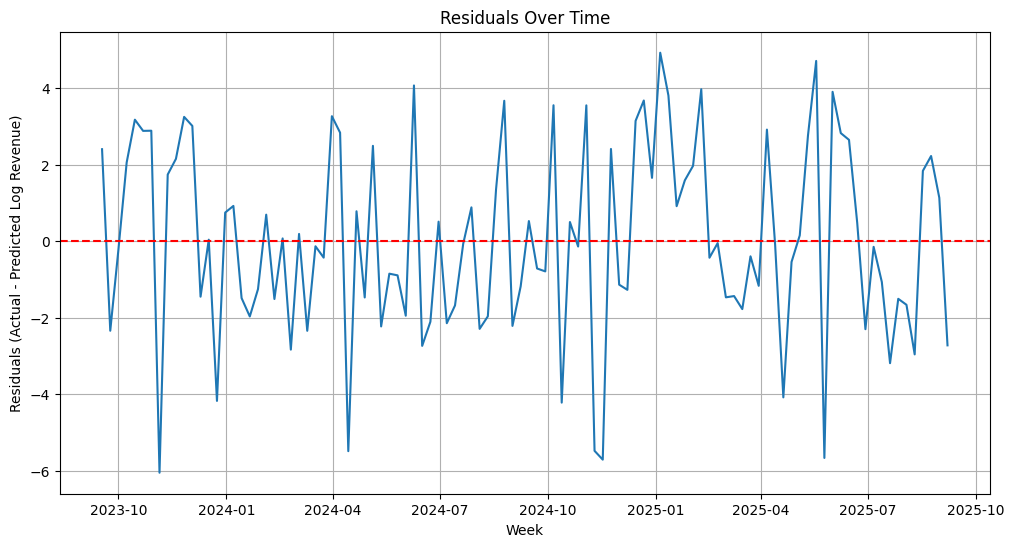

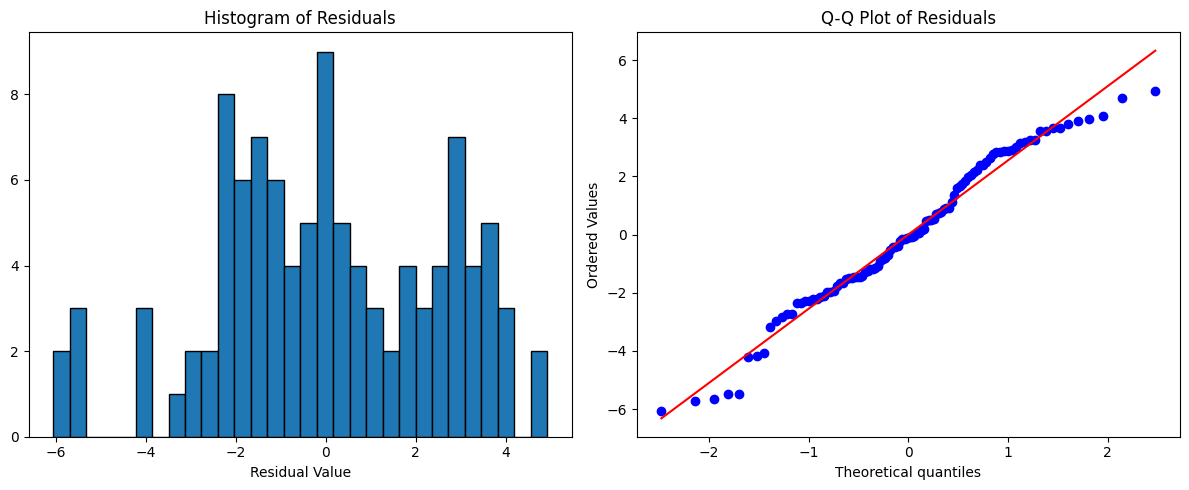

In [9]:
# Get final predictions on the entire dataset for residual analysis
final_predictions = final_stage2_model.predict(X2_final)
residuals = y2 - final_predictions

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(df_processed.index, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Week')
plt.ylabel('Residuals (Actual - Predicted Log Revenue)')
plt.grid(True)
plt.show()

# Histogram and Q-Q plot of residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(residuals, bins=30, edgecolor='black')
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residual Value')

import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

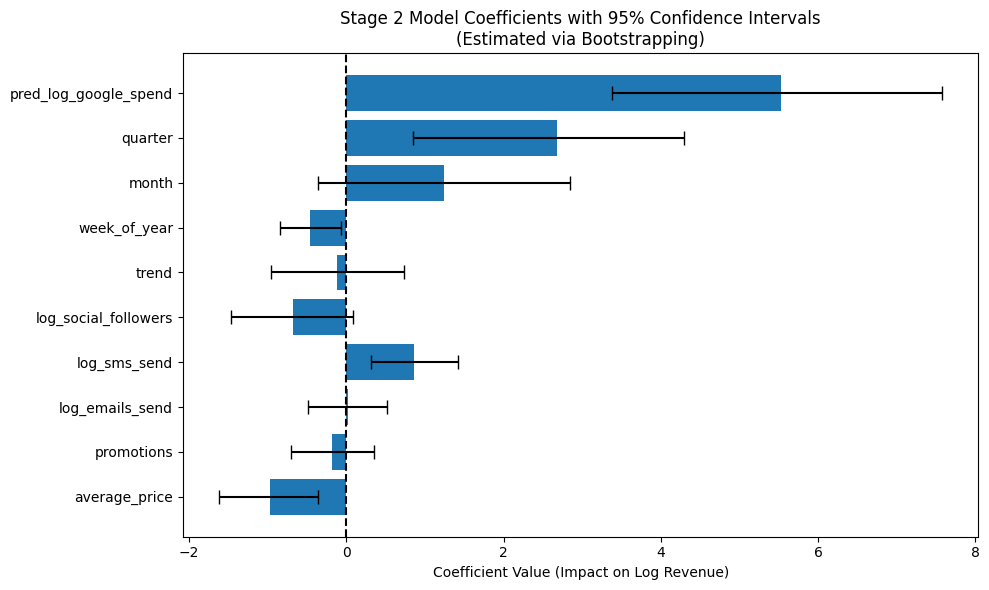

                 feature  mean_coefficient  ci_lower_95  ci_upper_95
9  pred_log_google_spend          5.527278     3.374451     7.576476
8                quarter          2.675481     0.852757     4.295284
7                  month          1.247126    -0.357435     2.847831
3           log_sms_send          0.864028     0.313536     1.420524
2        log_emails_send          0.029071    -0.489942     0.514833
5                  trend         -0.112882    -0.954377     0.733581
1             promotions         -0.182278    -0.704862     0.347605
6           week_of_year         -0.458927    -0.839536    -0.060782
4   log_social_followers         -0.682328    -1.469457     0.084453
0          average_price         -0.969040    -1.615496    -0.355623


In [10]:
# Simple bootstrapping to get a sense of coefficient stability
n_bootstraps = 1000
coefs_stage2 = []

for _ in range(n_bootstraps):
    # Sample with replacement
    indices = np.random.choice(range(len(X2_final)), size=len(X2_final), replace=True)
    X_sample = X2_final.iloc[indices]
    y_sample = y2.iloc[indices]
    
    # Fit model on sample
    model = Ridge(alpha=1.0, random_state=None) # Note: random_state=None for variability
    model.fit(X_sample, y_sample)
    coefs_stage2.append(model.coef_)

# Calculate 95% confidence intervals for coefficients
coefs_stage2 = np.array(coefs_stage2)
ci_lower = np.percentile(coefs_stage2, 2.5, axis=0)
ci_upper = np.percentile(coefs_stage2, 97.5, axis=0)
mean_coefs = np.mean(coefs_stage2, axis=0)

# Create a summary DataFrame for Stage 2 coefficients
coef_summary_df = pd.DataFrame({
    'feature': X2_final.columns,
    'mean_coefficient': mean_coefs,
    'ci_lower_95': ci_lower,
    'ci_upper_95': ci_upper
})

# Plot the coefficients with confidence intervals
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(coef_summary_df))
plt.barh(y_pos, coef_summary_df['mean_coefficient'], xerr=[mean_coefs - ci_lower, ci_upper - mean_coefs], capsize=5)
plt.yticks(y_pos, coef_summary_df['feature'])
plt.xlabel('Coefficient Value (Impact on Log Revenue)')
plt.title('Stage 2 Model Coefficients with 95% Confidence Intervals\n(Estimated via Bootstrapping)')
plt.axvline(x=0, color='k', linestyle='--')
plt.tight_layout()
plt.show()

print(coef_summary_df.sort_values(by='mean_coefficient', ascending=False))

In [11]:
# Since we have log-log model (or semi-log), coefficients can be interpreted as elasticities.
# A 1% increase in spend leads to a (coefficient)% increase in revenue.
# We can calculate the approximate ROAS for a channel by (Coefficient * Average Revenue) / Average Spend

# Get average revenue and average spends from the ORIGINAL (untransformed) data
avg_revenue = df['revenue'].mean()
avg_facebook_spend = df['facebook_spend'][df['facebook_spend'] > 0].mean() # Use mean of non-zero spends
avg_google_spend = df['google_spend'][df['google_spend'] > 0].mean()

# Find the coefficient for predicted Google spend in Stage 2
google_coef = coef_summary_df[coef_summary_df['feature'] == 'pred_log_google_spend']['mean_coefficient'].values[0]

# Find the coefficient for Facebook in Stage 1
facebook_coef_stage1 = coef_stage1[coef_stage1['feature'] == 'log_facebook_spend']['coefficient'].values[0]

# Calculate the overall mediated effect of Facebook on Revenue
# via Google: (Effect of Facebook on Google) * (Effect of Google on Revenue)
mediated_effect_facebook = facebook_coef_stage1 * google_coef

# Calculate approximate ROAS for Facebook ($ of revenue per $ of spend)
# ROAS ≈ (Elasticity * Average Revenue) / Average Spend
roas_facebook_mediated = (mediated_effect_facebook * avg_revenue) / avg_facebook_spend

print(f"Average Weekly Revenue: ${avg_revenue:,.2f}")
print(f"Average Facebook Spend (when spending): ${avg_facebook_spend:,.2f}")
print(f"---")
print(f"Estimated mediated effect of Facebook on Revenue (via Google): {mediated_effect_facebook:.4f}")
print(f"Approximate ROAS for Facebook (mediated through Google): ${roas_facebook_mediated:.2f}")

Average Weekly Revenue: $49,053.95
Average Facebook Spend (when spending): $5,347.30
---
Estimated mediated effect of Facebook on Revenue (via Google): -0.4736
Approximate ROAS for Facebook (mediated through Google): $-4.34
